In [1]:
import numpy as np
import scipy
from astroML.datasets import fetch_sdss_galaxy_colors
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [2]:
dataset = fetch_sdss_galaxy_colors()

In [3]:
colors = ['u', 'g', 'r', 'i', 'z', 'redshift']

In [4]:
data = np.array([dataset[c] for c in colors]).T
labels = dataset['specClass']
targets = (labels=='GALAXY').astype(np.float)

In [5]:
print('fraction of GALAXY class:', (targets==1).mean())
print('fraction of QSO class:', (targets==0).mean())

fraction of GALAXY class: 0.85384
fraction of QSO class: 0.14616


In [6]:
x_train, x_test, y_train, y_test = train_test_split(data, targets, test_size=0.2, random_state=42)

In [7]:
print('Training data:\nfraction of GALAXY class:', (y_train==1).mean())
print('fraction of QSO class:', (y_train==0).mean())
print('Test data:\nfraction of GALAXY class:', (y_test==1).mean())
print('fraction of QSO class:', (y_test==0).mean())

Training data:
fraction of GALAXY class: 0.853675
fraction of QSO class: 0.146325
Test data:
fraction of GALAXY class: 0.8545
fraction of QSO class: 0.1455


# $u-g$ vs $g-r$ 

In [8]:
dat = dataset[::10]
ug = dat['u'] - dat['g']
gr = dat['g'] - dat['r']

galaxies = (dat['specClass'] == 'GALAXY')
qsos = (dat['specClass'] == 'QSO')

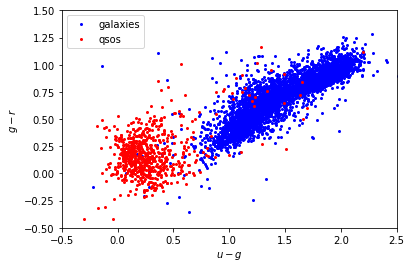

In [9]:
# Prepare plot
fig = plt.figure()

plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1.5)

plt.plot(ug[galaxies], gr[galaxies], '.', ms=4, c='b', label='galaxies')
plt.plot(ug[qsos], gr[qsos], '.', ms=4, c='r', label='qsos')

plt.legend(loc=2)

plt.xlabel('$u-g$')
plt.ylabel('$g-r$')

plt.show()

# PCA

In [10]:
pca = PCA(n_components=2)

In [11]:
X = pca.fit_transform(data)

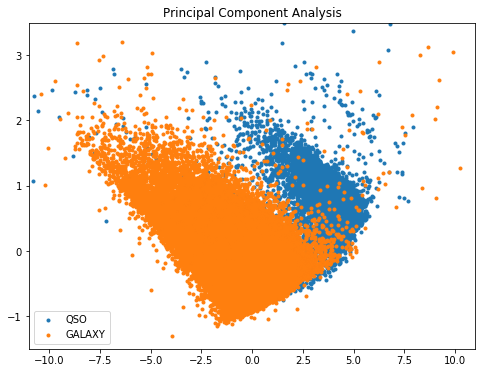

In [12]:
plt.figure(figsize=(8,6))
plt.scatter(X[targets==0,0], X[targets==0, 1], marker='.', label='QSO')
plt.scatter(X[targets==1,0], X[targets==1, 1], marker='.', label='GALAXY')
plt.xlim(-11,11); plt.ylim(-1.5, 3.5)
plt.legend()
plt.title('Principal Component Analysis')
plt.savefig('pca.png')
plt.show()

# Support Vector Machine

In [13]:
svm_classifier = SVC(kernel='linear', probability=True, tol=5e-4)

In [14]:
svm_classifier.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True,
    tol=0.0005, verbose=False)

In [15]:
print('Accuracy on training data:', svm_classifier.score(x_train, y_train))
print('Accuracy on test data:', svm_classifier.score(x_test, y_test))

Accuracy on training data: 0.990025
Accuracy on test data: 0.9901


In [16]:
p_train = svm_classifier.predict_proba(x_train)[:, 1]
p_test  = svm_classifier.predict_proba(x_test)[:, 1]

In [17]:
roc_auc_score(y_true=y_train, y_score=p_train)
roc_auc_score(y_true=y_test, y_score=p_test)

0.9924481469640211

In [18]:
train_fpr, train_tpr, train_thresholds = roc_curve(y_true=y_train, y_score=p_train)
test_fpr, test_tpr, test_thresholds = roc_curve(y_true=y_test, y_score=p_test)

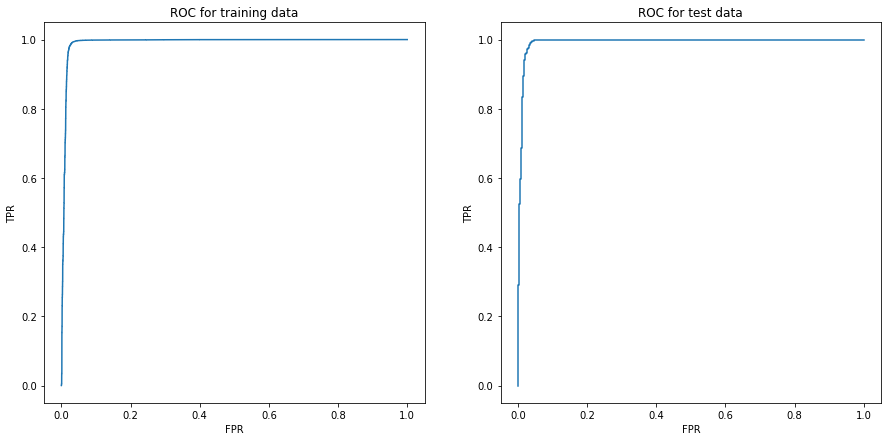

In [19]:
fig = plt.figure(figsize=(15, 7))

ax1 = fig.add_subplot(121)
ax1.plot(train_fpr, train_tpr)
ax1.set_xlabel('FPR'); ax1.set_ylabel('TPR')
ax1.set_title('ROC for training data')

ax2 = fig.add_subplot(122)
ax2.plot(test_fpr, test_tpr)
ax2.set_xlabel('FPR'); ax2.set_ylabel('TPR')
ax2.set_title('ROC for test data')

plt.savefig('roc.png')
plt.show()

# KNN 

In [20]:
k_values = [1, 5, 10, 50, 500, 1000]
print('k  accuracy')
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    print(k, knn.score(x_test, y_test))

k  accuracy
1 0.9875
5 0.9904
10 0.9898
50 0.9853
500 0.9779
1000 0.9742
